# Cleanning notebook 

Let's first call the libraries I'll use : 

In [1]:
data_path = "/home/clairegayral/Documents/openclassroom/data/"

# On importe les librairies dont on aura besoin pour ce tp
import numpy as np
import pandas as pd
## plot : 
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [15, 5]
## stat / model : 
from sklearn.model_selection import train_test_split

import itertools as IT

# 1. Import data : 

I have decided to extract the data labeled with the french nutriscore, to set a cleanning method and then decide the application I want to propose. I have in a first place look at a small subset extracted with the website interface, then I downloaded the big data they propose ($10^6$ products). 

- [ ] **Afterwards I would like to fetch from their json API.**

In [2]:
# ## 
# ## SMALL DATA SET (calories > 0)
# ##

# filename = data_path+"openfoodfacts_with_cholesterol.csv"
# df = pd.read_csv(filename,"\t")

In [3]:
##
## THE BIG DATA SET :
##

filename = data_path+"en.openfoodfacts.org.products.csv"

# GET THE NUMBER OF LINES : 
# bash code : cat en.openfoodfacts.org.products.csv | wc -l
# pandas (long to run) : print(pd.read_csv(filename, sep = "\t", usecols = ["code"],dtype = "str", squeeze=True))
with open(filename) as f:
    print("Number of products in the csv :", len(f.readlines())-1)

## GET INDEX OF NUTRI SCORE IN COLUMNS : 
tmp = pd.read_csv(filename, sep = "\t", nrows = 1).columns
col_index = np.where(tmp=="nutrition-score-fr_100g")[0][0]
col_index

## OPEN FILE WITH ITERATOR CHUNKS SELECTING ROWS WITH INFO ON col_index : :
def valid(chunks):
    for chunk in chunks:
        mask = ~chunk.iloc[:,col_index].isna().values
        yield chunk.loc[mask]            
chunksize = 10 ** 4
chunks = pd.read_csv(filename, sep = "\t", low_memory=False, chunksize=chunksize, header=None)
df_original = pd.concat(valid(chunks))
print("Number of variables : ", df_original.shape[1])
print("Number of product selected : ", df_original.shape[0])

Number of products in the csv : 1716277
Number of variables :  184
Number of product selected :  646577


The chunk method does not allow to set header, so let's do it : 

In [4]:
df = df_original.drop(0, axis=0)
df.columns = df_original.loc[0,:]
n = df.shape[0]
df.head(2)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
4,0000000000100,http://world-en.openfoodfacts.org/product/0000...,del51,1444572561,2015-10-11T14:09:21Z,1444659212,2015-10-12T14:13:32Z,moutarde au moût de raisin,NaN,NaN,...,NaN,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,0000000000949,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1523440813,2018-04-11T10:00:13Z,1565268412,2019-08-08T12:46:52Z,Salade de carottes râpées,NaN,NaN,...,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The data is huge ({{df.shape[0]}} products).
Let's first work on a sample of size 10 000, and then comment this part : 

In [5]:
df = df.sample(10000, replace = False)
df.shape

(10000, 184)

## 1.1 Drop Missing values : 
Let's remove the variables with too much NaN. First, I remove the columns filled with NaNs (there is no information in them). 

Then, I have chosen to keep the 1st quantile value of the number of NaNs in each variables : 
* if the variable has less NaNs than this quantile, I will estimate the missing value with KNN procedure, 
* else, I drop the corresponding column. 

In [6]:
##
## TACKLE MISSING VALUES 1 (drop col)
##

## DROP COL FILLED WITH NANs
df = df.loc[:,df.isna().sum(axis=0)<n]
print("There are ", sum(df.isna().sum(axis=0)==n), "variables without any information (all NaNs)")

## DROP COL WITH MORE NANs THAN THE MEAN/1st QUANTILE :
nan_repartition = df.isna().sum(axis=0)
# nan_threshold = nan_repartition.quantile(0.25)
nan_threshold = nan_repartition.mean()
print("I drop variables with more than", nan_threshold, "NaNs")
df = df.drop(df.columns[nan_repartition>nan_threshold], axis = 1)
df.describe()

There are  0 variables without any information (all NaNs)
I drop variables with more than 7235.135869565217 NaNs


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,quantity,packaging,...,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g
count,10000,10000,10000,10000,10000,10000,10000,9972,3922,3021,...,9976.0,5842.0,9976.0,9986.0,9986.0,2785.0,2850.0,3631.0,3565.0,10000.0
unique,10000,10000,609,9909,9907,9853,9852,9393,1032,1454,...,1541.0,283.0,1161.0,1473.0,1440.0,437.0,298.0,397.0,486.0,78.0
top,96619757572,http://world-en.openfoodfacts.org/product/0032...,kiliweb,1587669975,2020-04-23T19:26:15Z,1614416584,2021-02-27T09:03:04Z,Aceite de oliva virgen extra,250 g,Kunststoff,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0
freq,1,1,3674,3,3,4,4,14,171,90,...,1425.0,1772.0,1019.0,1141.0,1141.0,1593.0,1770.0,1121.0,1043.0,537.0


## 1.2 Exploration of the different values :

Then, I used the description data in https://world.openfoodfacts.org/data/data-fields.txt, to separate the global data frame into sub-frames. 
Note : to transform the .txt into these lists of variables, I used the bash command : 

    cat data-fields.txt | cut -d " " -f 1 | sed s/://g | sed s/\$/\",/g | sed s/\^/\"/g > data_fields2.txt

In [7]:
# USE BASH cat data-fields.txt | cut -d " " -f 1 | sed s/://g | sed s/\$/\",/g | sed s/\^/\"/g > data_fields2.txt
list_of_characteristics = ["code","url","creator","created_t","created_datetime","last_modified_t",
                           "last_modified_datetime","product_name","generic_name","quantity"]
list_of_tags = ["packaging", "packaging_tags", "brands", "brands_tags", "categories",
                "categories_tags", "categories_fr","origins", "origins_tags","manufacturing_places",
                "manufacturing_places_tags", "labels", "labels_tags", "labels_fr", "emb_codes", 
                "emb_codes_tags", "first_packaging_code_geo", "cities", "cities_tags", 
                "purchase_places", "stores", "countries", "countries_tags", "countries_fr"]
list_of_ingredients = ["ingredients_text", "traces", "traces_tags"]
list_of_misc = ["serving_size", "no_nutriments", "additives_n", "additives", "additives_tags", 
                "ingredients_from_palm_oil_n", "ingredients_from_palm_oil", 
                "ingredients_from_palm_oil_tags", "ingredients_that_may_be_from_palm_oil_n", 
                "ingredients_that_may_be_from_palm_oil", "ingredients_that_may_be_from_palm_oil_tags", 
                "nutrition_grade_fr", "main_category", "main_category_fr", "image_url", 
                "image_small_url"]
list_of_nutri_facts = ["energy_100g","energy-kj_100g","energy-kcal_100g","proteins_100g","casein_100g",
                       "serum-proteins_100g","nucleotides_100g","carbohydrates_100g","sugars_100g",
                       "sucrose_100g","glucose_100g","fructose_100g","lactose_100g","maltose_100g",
                       "maltodextrins_100g","starch_100g","polyols_100g","fat_100g","saturated-fat_100g",
                       "butyric-acid_100g","caproic-acid_100g","caprylic-acid_100g","capric-acid_100g",
                       "lauric-acid_100g","myristic-acid_100g","palmitic-acid_100g","stearic-acid_100g",
                       "arachidic-acid_100g","behenic-acid_100g","lignoceric-acid_100g","cerotic-acid_100g",
                       "montanic-acid_100g","melissic-acid_100g","monounsaturated-fat_100g",
                       "polyunsaturated-fat_100g","omega-3-fat_100g","alpha-linolenic-acid_100g",
                       "eicosapentaenoic-acid_100g","docosahexaenoic-acid_100g","omega-6-fat_100g",
                       "linoleic-acid_100g","arachidonic-acid_100g","gamma-linolenic-acid_100g",
                       "dihomo-gamma-linolenic-acid_100g","omega-9-fat_100g","oleic-acid_100g",
                       "elaidic-acid_100g","gondoic-acid_100g","mead-acid_100g","erucic-acid_100g",
                       "nervonic-acid_100g","trans-fat_100g","cholesterol_100g","fiber_100g","sodium_100g",
                       "alcohol_100g","vitamin-a_100g","vitamin-d_100g","vitamin-e_100g","vitamin-k_100g",
                       "vitamin-c_100g","vitamin-b1_100g","vitamin-b2_100g","vitamin-pp_100g",
                       "vitamin-b6_100g","vitamin-b9_100g","vitamin-b12_100g","biotin_100g",
                       "pantothenic-acid_100g","silica_100g","bicarbonate_100g","potassium_100g",
                       "chloride_100g","calcium_100g","phosphorus_100g","iron_100g","magnesium_100g",
                       "zinc_100g","copper_100g","manganese_100g","fluoride_100g","selenium_100g",
                       "chromium_100g","molybdenum_100g","iodine_100g","caffeine_100g","taurine_100g",
                       "ph_100g","fruits-vegetables-nuts_100g","carbon-footprint_100g",
                       "nutrition-score-fr_100g","nutrition-score-uk_100g"]

Then I used this partition to explore the data : these category allowed me to have an idea of the values of each variable in one hand and to determine the good type of each variable (set just after). I used the following functionm changing the category of the varibles. To ease the re-utilisation of this code, I commented the different possibilities : 

In [8]:
def print_values_from_list_of_var(df_,list_of_var):
    for var in list_of_var : 
        if var in df_.columns:
            print("--",var)
            tmp = df_[df_.columns.intersection([var])]
            var_values = tmp.iloc[(~pd.isna(tmp).values)]
            if len(var_values) < 8:
                print("values = ", var_values.values)
            else :
                print("ex of values = ", 
                      np.array(tmp.iloc[(~pd.isna(tmp).values)].sample(n=8).values).transpose()[0])
        else : 
            print("--", var, " : no data")
            
# list_of_var = list_of_characteristics
# list_of_var = list_of_tags
# list_of_var = list_of_ingredients
# list_of_var = list_of_misc
list_of_var = list_of_nutri_facts
print_values_from_list_of_var(df,list_of_var)

-- energy_100g
ex of values =  [184.0 1987.0 1494.0 1063.0 176.0 975.0 1146.0 197.0]
-- energy-kj_100g  : no data
-- energy-kcal_100g
ex of values =  [51.0 377.0 119.0 48.0 43.0 92.0 104.0 372.0]
-- proteins_100g
ex of values =  [6.0 7.5 46.43 13.5 6.6 0.83 5.88 0.9]
-- casein_100g  : no data
-- serum-proteins_100g  : no data
-- nucleotides_100g  : no data
-- carbohydrates_100g
ex of values =  [77.42 93.33 48.0 4.9 2.9 19.7 49.7 9.0]
-- sugars_100g
ex of values =  [0.88 3.33 64.8 10.9 0.0 6.5 8.7 1.4]
-- sucrose_100g  : no data
-- glucose_100g  : no data
-- fructose_100g  : no data
-- lactose_100g  : no data
-- maltose_100g  : no data
-- maltodextrins_100g  : no data
-- starch_100g  : no data
-- polyols_100g  : no data
-- fat_100g
ex of values =  [67.0 0.0 5.71 12.0 5.0 26.0 11.11 0.1]
-- saturated-fat_100g
ex of values =  [0.0 3.33 1.1 10.7 0.62 10.5 9.7 17.95]
-- butyric-acid_100g  : no data
-- caproic-acid_100g  : no data
-- caprylic-acid_100g  : no data
-- capric-acid_100g  : no da

This variable-type analysis allowed me to select the non-relevant variables for my study, such as the dates. I have keep some variables like the country or the name of the person that put the product in the database, just for the exercice to clean text data. This subset will be call "data" :

In [20]:
interest_var = pd.Index(["code","creator","countries","additives_n","ingredients_from_palm_oil_n",
                "ingredients_that_may_be_from_palm_oil_tags"])
interest_var = interest_var.append(df.columns.intersection(list_of_nutri_facts))

data = df[df.columns.intersection(interest_var)].copy()
# data = data.fillna(pd.NA)

In [21]:
### GESTION DES TYPES DANS DATA !!
## STR 
str_var = list_of_characteristics 
str_var += list_of_tags
str_var += list_of_ingredients
str_var += list_of_misc
str_var = data.columns.intersection(str_var)
data[str_var] = data[str_var].astype("str")

## FLOATS (and INTs)
float_var = list_of_nutri_facts
float_var += ["additives_n", "ingredients_from_palm_oil_n", "ingredients_that_may_be_from_palm_oil_tags"]
float_var = data.columns.intersection(float_var)
data[float_var] = data[float_var].astype("float")

## CATEGORY
data[["creator","nutrition-score-fr_100g"]] = data[["creator","nutrition-score-fr_100g"]].astype("category")
# data.dtypes

Now that the float types are ok, I can call the "describe" method of pandas, to see the summary of the descriptive statistics : 

In [22]:
data.describe()

,additives_n,ingredients_from_palm_oil_n,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g
count,7321.000000,7321.000000,9293.000000,9977.000000,9976.000000,9976.000000,3508.000000,3585.000000,9970.000000,9976.000000,5842.000000,9976.000000,9986.000000,2785.000000,2850.000000,3631.000000,3565.000000
mean,2.076083,0.016938,280.361700,1167.858257,14.512799,5.395930,0.043432,0.020033,27.986918,13.044518,2.902510,8.454402,0.459434,0.000156,0.011973,0.152235,0.018092
std,2.942682,0.130101,201.068159,833.052838,17.789848,8.147719,0.764498,0.149654,27.962836,18.561523,4.686038,8.826798,1.536959,0.001972,0.233691,2.238069,0.771082
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,107.000000,448.000000,1.100000,0.100000,0.000000,0.000000,4.000000,0.800000,0.000000,2.000000,0.040000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,265.000000,1096.000000,8.100000,2.000000,0.000000,0.000000,16.000000,3.800000,1.500000,6.060000,0.240000,0.000000,0.000000,0.038000,0.000970
75%,3.000000,0.000000,407.000000,1699.000000,23.000000,7.790000,0.000000,0.021000,52.500000,19.000000,3.600000,12.000000,0.532000,0.000100,0.003700,0.111000,0.002460
max,27.000000,2.000000,4614.000000,19305.000000,100.000000,95.000000,39.290000,8.750000,629.000000,100.000000,87.500000,91.666667,67.700000,0.102000,12.000000,120.000000,45.200000


# 1.3 Errors in data :
We need to check if there are : 
* lexical errors
* irregularity error
* Formatage error
* Duplicates
* Outliers

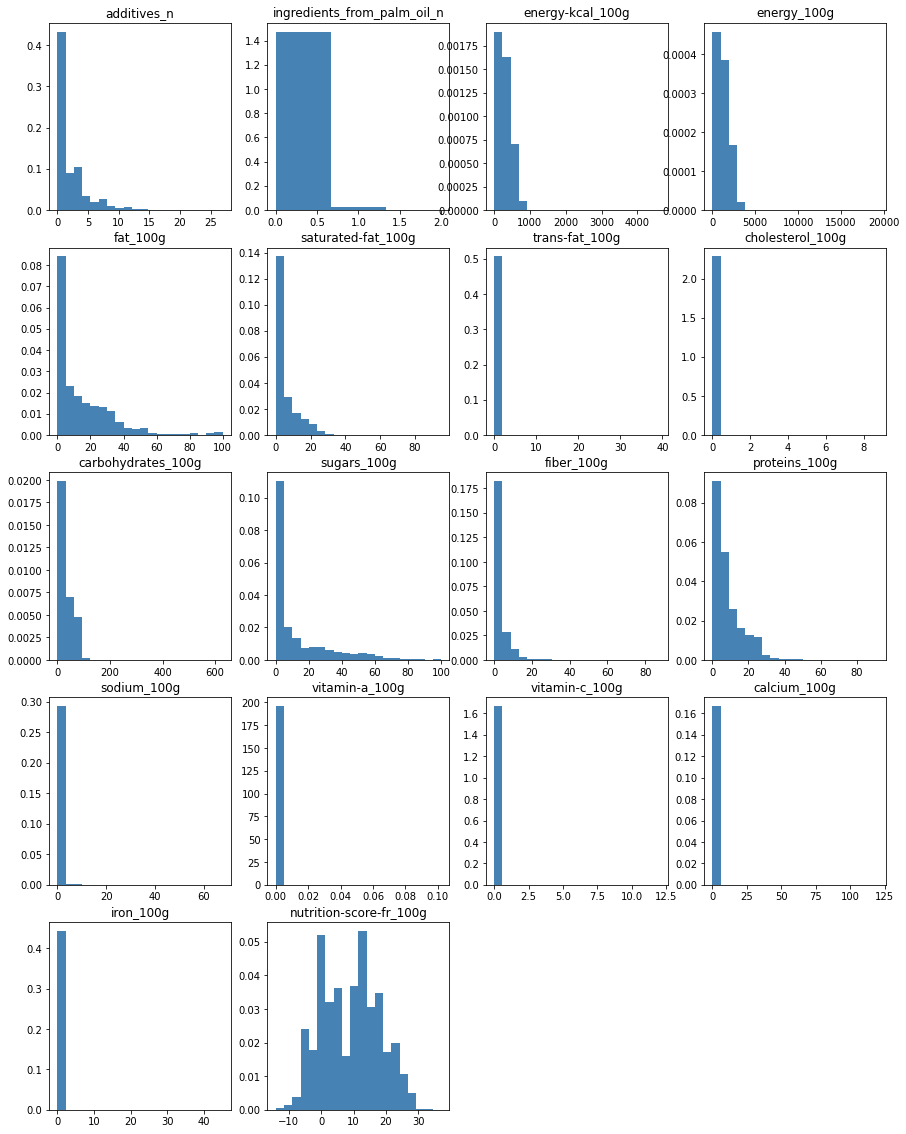

In [23]:
nb_line_plot = int(np.floor(len(float_var)/4)+1)
fig = plt.figure(figsize=(15, 20))

fig_count = 1
for var in float_var :#data.columns.intersection(list_of_nutri_facts):
    ax = fig.add_subplot(nb_line_plot,4, fig_count,)
    nb_bins = min(20, len(np.unique(data[var].dropna().values)))
    ax.hist(data[var], bins = nb_bins, color='steelblue', density=True, edgecolor='none')
    ax.set_title(var)
    fig_count += 1
plt.show()

To ease this manual part, I used the following function :
**put the box with "extract_irreg_errors" here**

In [64]:
def extract_irreg_errors_val(colname,possible_values, data = data):
    outliers_val = []
    col_values = data[colname].drop_duplicates().values
    ## check possible values : 
    min_value, max_value = possible_values
    for val in col_values :
        if ~np.isnan(val) :
            if (val < min_value) or (val >= max_value):
                outliers_val.append(val)
        else : 
            print(sum(data[colname].isna()),"missing values")
    print(len(outliers_val), "irregular errors")
    return outliers_val

I decided to modify some of my variables : 
* if there is no "ingredients_from_palm_oil" but a "ingredients_from_palm_oil_n" colunm, I transformed this one into the first one.


In [65]:
############## dev code ###################
##
## 1st idea of code : 
##
data2 = data.copy()
if "ingredients_from_palm_oil_n" in data2.columns :
    if ~("ingredients_from_palm_oil" in data2.columns) :
        data2.insert(loc = data2.columns.get_loc("ingredients_from_palm_oil_n"),
                    column = "ingredients_from_palm_oil",
                    value = 0)
        index_1 = data2[data2["ingredients_from_palm_oil_n"]==1].index
        data2.at[index_1,"ingredients_from_palm_oil"] = 1
        index_nan = data2[pd.isna(data2["ingredients_from_palm_oil_n"])].index
        data2.at[index_nan,"ingredients_from_palm_oil"] = np.nan
        
    data2.drop("ingredients_from_palm_oil_n", axis=1, inplace = True)
data2.iloc[:,3:10]

## 
## after reflexion, better to do modify directly the line :
##
data2 = data.copy()
if "ingredients_from_palm_oil_n" in data2.columns :
    if ~("ingredients_from_palm_oil" in data2.columns) :
        data2.at[data2["ingredients_from_palm_oil_n"] > 0, "ingredients_from_palm_oil_n"] = 1
        data2.rename(columns={"ingredients_from_palm_oil_n":"ingredients_from_palm_oil"}, inplace=True)

I start to isolate the code I want to re-use to define my prepocess method (idea : object oriented programmation)

In [66]:
def preprocess_data(data):
    if "ingredients_from_palm_oil_n" in data.columns :
        if ~("ingredients_from_palm_oil" in data.columns) :
            data.at[data["ingredients_from_palm_oil_n"] > 0, "ingredients_from_palm_oil_n"] = 1
            data.rename(columns={"ingredients_from_palm_oil_n":"ingredients_from_palm_oil"}, inplace=True)
preprocess_data(data)

I made a dictionnary of the possible values each variable can take : 

For clarity purposes, I just keep an example of how I proceeded to choose my possible values for each variable :

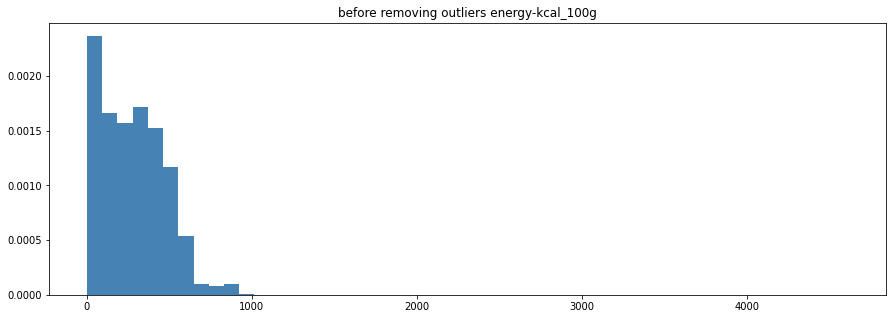

707 missing values
6 irregular errors


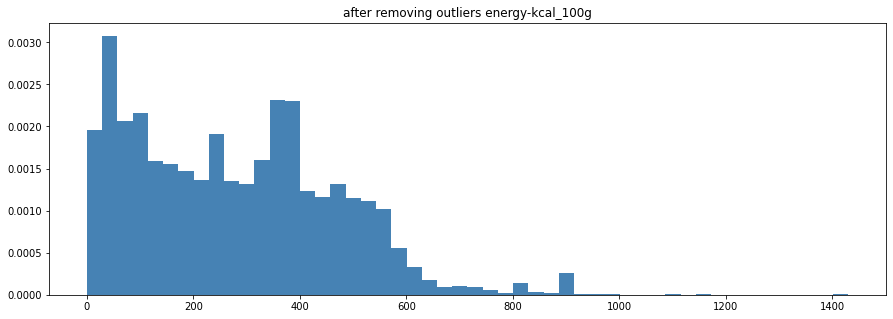

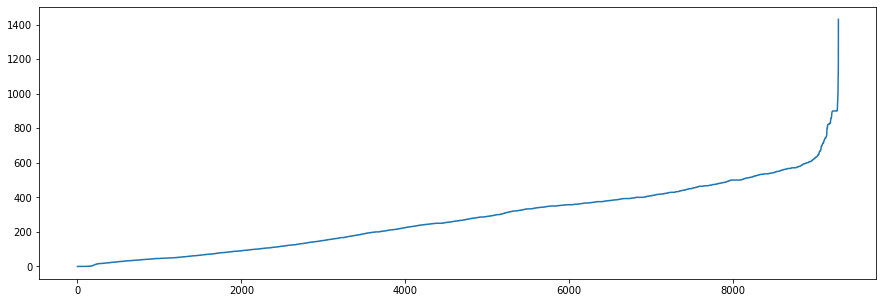

707 missing values
12 irregular errors


array(['Happy Snacks Animal Crackers', 'Mozzarella',
       "Confiture D'abricot Et Amandes Effilées", 'Light mayo', 'NESQUIK',
       'bastoncini di crusca'], dtype=object)

In [68]:
data2 = data.copy()
colname = "energy-kcal_100g"
possible_values = [0,1500]

## Histogramme global 
nb_bins = min(50, len(np.unique(data2[colname].dropna().values)))
plt.hist(data2[colname], bins = nb_bins, color='steelblue', density=True, edgecolor='none')
plt.title("before removing outliers " + colname)
plt.show()

outliers = extract_irreg_errors_val(colname,possible_values, data = data2)
# val_index = data.loc[(data[colname] in outliers),:].index.values
data2.at[data2[colname].isin(outliers)] = np.nan

## Histogramme : 
nb_bins = min(50, len(np.unique(data2[colname].dropna().values)))
plt.hist(data2[colname], bins = nb_bins, color='steelblue', density=True, edgecolor='none')
plt.title("after removing outliers " + colname)
plt.show()
# plot values : 
plt.plot(np.sort(data2[colname]))
plt.show()
really_fat = extract_irreg_errors_val(colname, [0,1000], data = data)

np.array(df.loc[data2[colname].isin(really_fat), "product_name"])


In [69]:
possible_val_dict = {'additives_n' : [0,35],'ingredients_from_palm_oil': [0,1],
                     'energy-kcal_100g':[0,1500], 'energy_100g':[0,5000]},
#                        'fat_100g', 'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g',
#                        'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
#                        'sodium_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'calcium_100g',
#                        'iron_100g', 'nutrition-score-fr_100g'}

limit_val_dict = {'additives_n' : [0,30],'ingredients_from_palm_oil': [0,1],
                     'energy-kcal_100g':[0,1000], 'energy_100g':[0,4000]},
#                        'fat_100g', 'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g',
#                        'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
#                        'sodium_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'calcium_100g',
#                        'iron_100g', 'nutrition-score-fr_100g'}


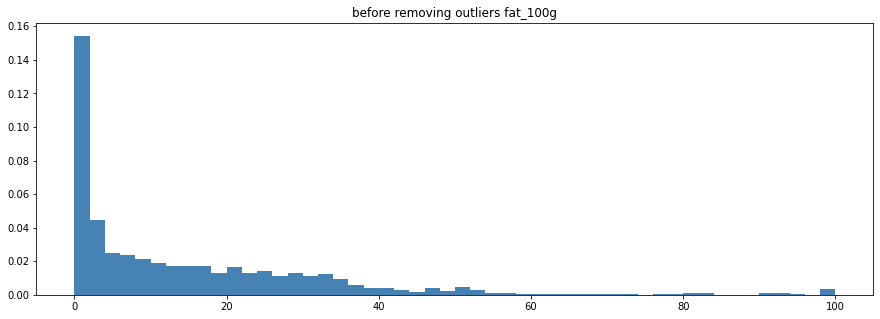

24 missing values
1 irregular errors


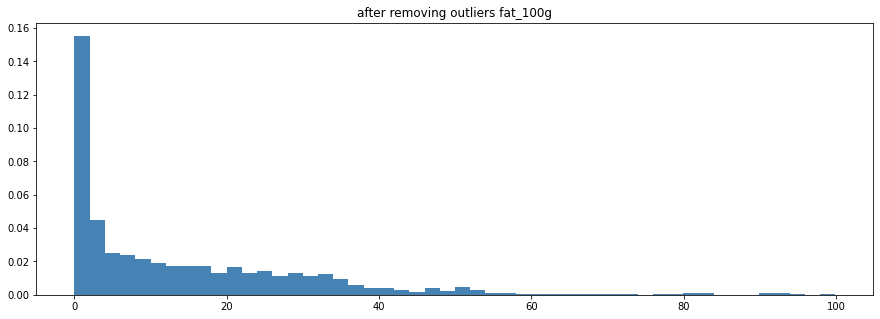

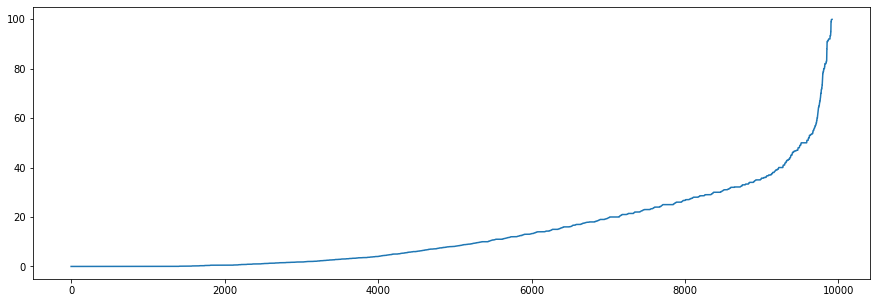

24 missing values
1 irregular errors


array([], dtype=object)

In [71]:
data2 = data.copy()
colname = "fat_100g"
possible_values = [0,100]

## Histogramme global 
nb_bins = min(50, len(np.unique(data2[colname].dropna().values)))
plt.hist(data2[colname], bins = nb_bins, color='steelblue', density=True, edgecolor='none')
plt.title("before removing outliers " + colname)
plt.show()    

outliers = extract_irreg_errors_val(colname,possible_values, data = data)
# val_index = data.loc[(data[colname] in outliers),:].index.values
data2.at[data2[colname].isin(outliers)] = np.nan

## Histogramme : 
nb_bins = min(50, len(np.unique(data2[colname].dropna().values)))
plt.hist(data2[colname], bins = nb_bins, color='steelblue', density=True, edgecolor='none')
plt.title("after removing outliers " + colname)
plt.show()
# plot values : 
plt.plot(np.sort(data2[colname]))
plt.show()

## Print problematic variables : 
really_fat = extract_irreg_errors_val(colname, [0,100], data = data)
np.array(df.loc[data2[colname].isin(really_fat), "product_name"])


In [ ]:
var = "energy_100g"
nb_bins = min(100, len(np.unique(data[var].dropna().values)))
creators_colors = 
plt.hist(data[var], bins = nb_bins, density=True, edgecolor='none', color = data["creator"])
plt.title(str(var))
print(np.array(data[var].values[:100]))

In [ ]:
df.creator.value_counts()[10:]

In [ ]:
df.groupby(df.columns.tolist()).size().reset_index().rename(columns={0:'count'})

In [ ]:
data.countries.drop_duplicates().values

In [ ]:
## countries VARIABLE TREATMENT (MORE COMPLICATED + TEXT) 
data.countries.drop_duplicates().values[:5]

# 1.3 Outliers 

Let's deal with outliers

# 1.4 Estimate remaining missing values

In [ ]:
import numpy as np
# x = np.array([4,8,12,20,40,60])

x = np.array([2,6,10,16,30,50])
dx = np.array([4,4,4,8,20,20])
n = np.array([40,60,100,160,80,60])
f = n/500
d =f/dx
m = x*f
m.sum()
(np.sqrt(275280/500-(9400/500)**2)-14)*60
0.15*0.9+0.85*0.3
0.9*0.15/0.39
0.9*0.85+0.3*0.15


In [ ]:
from mpl_toolkits import mplot3d
def f(x,y) :
    return x**3 + 3/2*y**2 + 3*x*y + 60

xline = np.linspace(-5, 5, 100)
yline = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(xline, yline)

Z = f(X,Y)
# ax.plot3D(X, Y, Z, 'gray')


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z,rstride=1, cmap='viridis', edgecolor='none')
ax.scatter(0, 0, f(0,0), color="red")
ax.scatter(1, -1, f(1,-1), color="black")
plt.show()

In [ ]:

ax.view_init(45,30)
fig

In [ ]:
f(0,0)
# f(1,-1)
